This module is used to calculate the actual energy and demand charges

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta

from settings import *

#### Load data and extract time series of solar power and building load

In [5]:
path_res = os.path.join("results", f"load_with_BESS_15min.csv")
data = pd.read_csv(path_res)
   
dts = np.array(data['datetime'])
PSs = np.array(data['solar_power'])
LBs = np.array(data['building_load'])
BESS_outputs = np.array(data['BESS_output'])

net_loads_original = LBs - PSs
net_loads = LBs - PSs - BESS_outputs

# define start and end date, as well as the target aggregation time interval
myd_start = "2022-05-31"
myd_end = "2022-06-01"
dt_start = datetime.strptime(f"{myd_start} 00:00:00", "%Y-%m-%d %H:%M:%S")
dt_end = datetime.strptime(f"{myd_end} 23:59:59", "%Y-%m-%d %H:%M:%S")
billing_interval = timedelta(minutes = 15)
billing_interval_hour = billing_interval.seconds/3600

#### Visualize the load w/ and w/o BESS

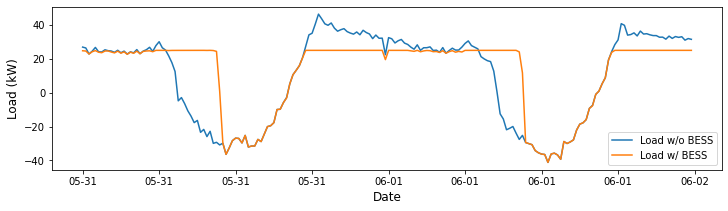

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

fig = plt.figure(figsize = (12,3))
ax = fig.add_subplot(111)

dates = pd.to_datetime(dts)
ax.plot(dates, net_loads_original, label = "Load w/o BESS")
ax.plot(dates, net_loads, label = "Load w/ BESS")
ax.set_xlabel('Date', fontsize = 12)
ax.set_ylabel('Load (kW)', fontsize = 12)
ax.legend(loc = 'lower right')

date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

#fig.savefig("imgs/load_compare.svg")

#### Cost audit

In [7]:
dict_net_loads = {"wo BESS": LBs - PSs,
                  "w BESS": LBs - PSs - BESS_outputs}
recorder = {}
N = len(dts)

for load_type in dict_net_loads.keys():
    net_loads = dict_net_loads[load_type]

    coste = {"Super Off-Peak": 0, "Off-Peak": 0, "On-Peak": 0}
    costd = {"On-Peak": 0, "Non-Coincident": 0, "Generation": 0}
    costE = {"Summer": coste.copy(), "Winter": coste.copy()}
    costD = {"Summer": costd.copy(), "Winter": costd.copy()}
    p_peaks = {"Summer": costd.copy(), "Winter": costd.copy()}
    time_count = {"Summer": 0, "Winter": 0}

    for i in range(N):
        dt = datetime.strptime(dts[i], "%Y%m%d-%H%M%S")

        # Determine weekday
        if dt.weekday() in [0, 1, 2, 3, 4]:
            # Determine month
            if dt.month in [3, 4]:
                peakHourTable = peakHourTable_weekdayMarApr
            else:
                peakHourTable = peakHourTable_weekday
        else:
            peakHourTable = peakHourTable_weekend

        # Determine season
        if dt.month in summerMonths:
            season = "Summer"
            energyChargeRef = energyChargeRef_Summer
            demandChargeRef = demandChargeRef_Summer
        else:
            season = "Winter"
            energyChargeRef = energyChargeRef_Winter
            demandChargeRef = demandChargeRef_Winter
        time_count[season] += 1

        # Get energy charge and demand charge at t
        peak_indicator = peakHourTable[dt.hour]
        peak_phase = peakNames[peak_indicator]
        ce = energyChargeRef[peak_indicator]
        costE[season][peak_phase] += ce * net_loads[i] * billing_interval_hour

        if net_loads[i] > p_peaks[season]["Non-Coincident"]:
            p_peaks[season]["Non-Coincident"] = net_loads[i]
        if peak_phase == "On-Peak":
            if net_loads[i] > p_peaks[season]["On-Peak"]:
                p_peaks[season]["On-Peak"] = net_loads[i]

    for season in p_peaks.keys():
        p_peaks[season]["Non-Coincident"] = max(p_peaks["Summer"]["Non-Coincident"], p_peaks["Winter"]["Non-Coincident"])
        p_peaks[season]["Generation"] = p_peaks[season]["Non-Coincident"]

    cds = {"Summer": {"On-Peak": cd_OnPeak_Summer,\
                      "Non-Coincident": cd_NonCoincident_Summer,\
                      "Generation": cd_Generation_Summer},
           "Winter": {"On-Peak": cd_OnPeak_Winter,\
                      "Non-Coincident": cd_NonCoincident_Winter,\
                      "Generation": cd_Generation_Winter}}
    for season in costD.keys():
        ratio = time_count[season]/(time_count["Summer"] + time_count["Winter"])
        for typ in costD[season].keys():
            costD[season][typ] = cds[season][typ] * p_peaks[season][typ] * ratio

    energyCharge = 0
    for season in costE.keys():
        for peak_phase in costE[season].keys():
            energyCharge += costE[season][peak_phase]

    demandCharge = 0
    for season in costD.keys():
        for typ in costD[season].keys():
            demandCharge += costD[season][typ]

    recorder[load_type] = {}
    recorder[load_type]["EnergyCharge"] = energyCharge
    recorder[load_type]["DemandCharge"] = demandCharge
    recorder[load_type]["TotalCharge"] = energyCharge + demandCharge


# Output results
#save_obj(recorder, f"costs-{myd_start}-to-{myd_end}-Vp{V_PEAK}-Vnp{V_NONPEAK}")

cewo, cew = recorder["wo BESS"]["EnergyCharge"], recorder["w BESS"]["EnergyCharge"]
cdwo, cdw = recorder["wo BESS"]["DemandCharge"], recorder["w BESS"]["DemandCharge"]
cwo, cw = recorder["wo BESS"]["TotalCharge"], recorder["w BESS"]["TotalCharge"]
print(f"{myd_start}, {myd_end}")
print(f"Energy Charge: {cewo} (w/o BESS), {cew} (w/ BESS)")
print(f"Demand Charge: {cdwo} (w/o BESS), {cdw} (w/ BESS)")
print(f"Total Charge: {cwo} (w/o BESS), {cw} (w/ BESS)")

2022-05-31, 2022-06-01
Energy Charge: 74.19602356375782 (w/o BESS), 79.52615942082573 (w/ BESS)
Demand Charge: 2861.007971769218 (w/o BESS), 1584.3750000000362 (w/ BESS)
Total Charge: 2935.203995332976 (w/o BESS), 1663.9011594208619 (w/ BESS)
